In [6]:
import numpy as np
import pandas as pd
import polars as pl

In [7]:
from pathlib import Path

PATH_DATA_RAW = Path("../../data/raw").resolve()

PATH_DATA_RAW

PosixPath('/beegfs/.global0/ws/s4610340-sleep_states/data/raw')

## Val split count

In [8]:
import hydra
import detect_sleep_states.config

with hydra.initialize_config_dir(
        version_base=None,
        config_dir="/beegfs/ws/0/s4610340-sleep_states/kaggle-detect_sleep_states/config"):
    cfg: detect_sleep_states.config.TrainConfig = hydra.compose(config_name="train")

total_series = len(cfg.split.train_series_ids) + len(cfg.split.valid_series_ids)

print(f"Total: {total_series}")
print(f"Train size: {len(cfg.split.train_series_ids)} ({len(cfg.split.train_series_ids) / total_series})")
print(f"Val size: {len(cfg.split.valid_series_ids)} ({len(cfg.split.valid_series_ids) / total_series})")

Total: 277
Train size: 221 (0.7978339350180506)
Val size: 56 (0.20216606498194944)


## Event df

In [9]:
df_train_events = pd.read_csv(PATH_DATA_RAW / "train_events.csv")
df_train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


## Train series df

In [10]:
df_train_series = pl.scan_parquet(PATH_DATA_RAW / "train_series.parquet").with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)
unique_series_id = df_train_series.select(pl.col("series_id")).unique().collect()
unique_series_id

series_id
str
"""292a75c0b94e"""
"""89c7daa72eee"""
"""e0686434d029"""
"""05e1944c3818"""
"""c5365a55ebb7"""
"""5acc9d63b5fd"""
"""12d01911d509"""
"""27f09a6a858f"""
"""dacc6d652e35"""


In [11]:
df_train_series.head(n=1).collect()

series_id,step,timestamp,anglez,enmo
str,u32,"datetime[μs, UTC]",f32,f32
"""038441c925bb""",0,2018-08-14 19:30:00 UTC,2.6367,0.0217


In [12]:
df_train_series.dtypes

[Utf8, UInt32, Datetime(time_unit='us', time_zone=None), Float32, Float32]

In [16]:
df_series: pl.DataFrame = df_train_series.filter(pl.col("series_id") == "ebb6fae8ed43").collect()
df_series = df_series.with_row_count("row_n").to_pandas()
df_series

,row_n,series_id,step,timestamp,anglez,enmo
0,0,ebb6fae8ed43,0,2018-05-11 20:15:00+00:00,-88.455299,0.0000
1,1,ebb6fae8ed43,1,2018-05-11 20:15:05+00:00,-88.455299,0.0000
2,2,ebb6fae8ed43,2,2018-05-11 20:15:10+00:00,-88.455299,0.0000
3,3,ebb6fae8ed43,3,2018-05-11 20:15:15+00:00,-88.455299,0.0000
4,4,ebb6fae8ed43,4,2018-05-11 20:15:20+00:00,-88.455299,0.0000
...,...,...,...,...,...,...
737815,737815,ebb6fae8ed43,737815,2018-06-23 12:59:35+00:00,-35.195400,0.0404
737816,737816,ebb6fae8ed43,737816,2018-06-23 12:59:40+00:00,-31.041000,0.0686
737817,737817,ebb6fae8ed43,737817,2018-06-23 12:59:45+00:00,-26.677099,0.0503
737818,737818,ebb6fae8ed43,737818,2018-06-23 12:59:50+00:00,-27.967800,0.0514


In [14]:
from numba import jit
from collections import defaultdict
from tqdm import tqdm
import numpy as np

@jit(nopython=True)
def calculate_removed_periods(
        anglez: np.ndarray,
        window_size: int,
        step: int
) -> np.ndarray:
    g_size = window_size
    step = step
    is_removed = np.repeat(False, len(anglez))
    for first_window_start in range(2 * g_size, len(anglez) - g_size, g_size):
        
        first_window_end = first_window_start + g_size
    
        for second_window_start in range(0, first_window_start - g_size, step):
    
            second_window_end = second_window_start + g_size
    
            if np.all(
                    anglez[first_window_start:first_window_end] == anglez[second_window_start:second_window_end]):
                is_removed[first_window_start:first_window_end] = True
                is_removed[second_window_start:second_window_end] = True
    return is_removed

In [17]:
df_series["is_removed"] = calculate_removed_periods(df_series["anglez"].to_numpy(), window_size=720, step=2)
df_series

,row_n,series_id,step,timestamp,anglez,enmo,is_removed
0,0,ebb6fae8ed43,0,2018-05-11 20:15:00+00:00,-88.455299,0.0000,False
1,1,ebb6fae8ed43,1,2018-05-11 20:15:05+00:00,-88.455299,0.0000,False
2,2,ebb6fae8ed43,2,2018-05-11 20:15:10+00:00,-88.455299,0.0000,False
3,3,ebb6fae8ed43,3,2018-05-11 20:15:15+00:00,-88.455299,0.0000,False
4,4,ebb6fae8ed43,4,2018-05-11 20:15:20+00:00,-88.455299,0.0000,False
...,...,...,...,...,...,...,...
737815,737815,ebb6fae8ed43,737815,2018-06-23 12:59:35+00:00,-35.195400,0.0404,False
737816,737816,ebb6fae8ed43,737816,2018-06-23 12:59:40+00:00,-31.041000,0.0686,False
737817,737817,ebb6fae8ed43,737817,2018-06-23 12:59:45+00:00,-26.677099,0.0503,False
737818,737818,ebb6fae8ed43,737818,2018-06-23 12:59:50+00:00,-27.967800,0.0514,False


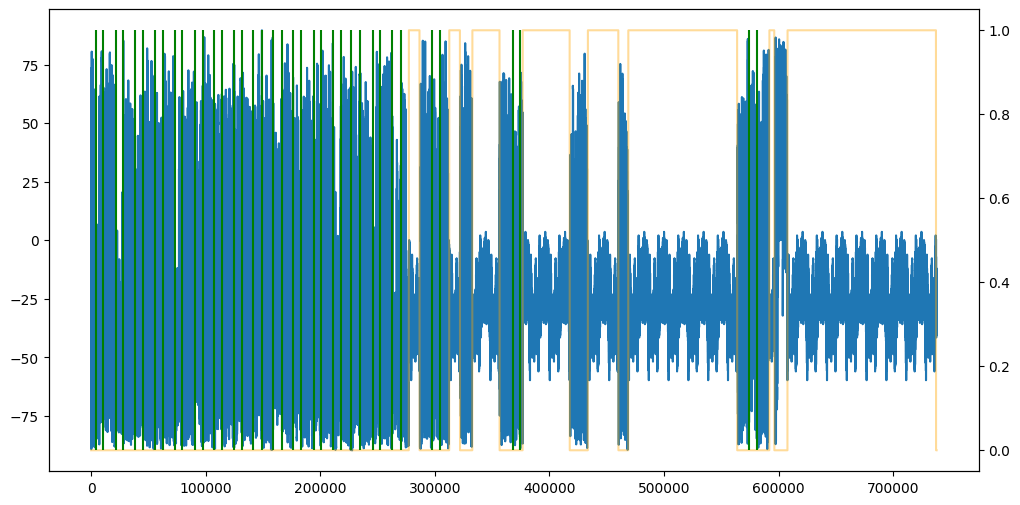

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_series["anglez"])
ax_2 = ax.twinx()
ax_2.plot(df_series["step"], df_series["is_removed"], color="orange", alpha=0.4)

series_events = df_train_events.loc[df_train_events["series_id"]==df_series["series_id"][0]]
ax_2.vlines(series_events["step"].dropna(), ymin=0, ymax=1, color="green")